# Juan Felipe Osorio Franco

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# Librerías para preprocesamiento y modelado
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

# Ruta al archivo CSV
csv_path = 'data.csv'

# Cargar los datos
Xdata = pd.read_csv(csv_path)

# Columnas a descartar por no contener información relevante
col_drop = ['Unnamed: 0', 'Name', 'ID', 'Photo', 'Flag',
            'Club Logo', 'Loaned From']

# Eliminar las columnas no relevantes
Xdata.drop(columns=col_drop, inplace=True)

# Mostrar las primeras filas del DataFrame
Xdata.head()

,Age,Nationality,Overall,Potential,Club,Value,Wage,Special,Preferred Foot,International Reputation,...,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
0,31,Argentina,94,94,FC Barcelona,€110.5M,€565K,2202,Left,5.0,...,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,€226.5M
1,33,Portugal,94,94,Juventus,€77M,€405K,2228,Right,5.0,...,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,€127.1M
2,26,Brazil,92,93,Paris Saint-Germain,€118.5M,€290K,2143,Right,5.0,...,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,€228.1M
3,27,Spain,91,93,Manchester United,€72M,€260K,1471,Right,4.0,...,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,€138.6M
4,27,Belgium,91,92,Manchester City,€102M,€355K,2281,Right,4.0,...,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,€196.4M


In [39]:
# Información general del DataFrame
Xdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18207 entries, 0 to 18206
Data columns (total 82 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Age                       18207 non-null  int64  
 1   Nationality               18207 non-null  object 
 2   Overall                   18207 non-null  int64  
 3   Potential                 18207 non-null  int64  
 4   Club                      17966 non-null  object 
 5   Value                     18207 non-null  object 
 6   Wage                      18207 non-null  object 
 7   Special                   18207 non-null  int64  
 8   Preferred Foot            18159 non-null  object 
 9   International Reputation  18159 non-null  float64
 10  Weak Foot                 18159 non-null  float64
 11  Skill Moves               18159 non-null  float64
 12  Work Rate                 18159 non-null  object 
 13  Body Type                 18159 non-null  object 
 14  Real F

In [40]:
# Definir la variable objetivo
col_sal = "Release Clause"

# Separar la variable objetivo del conjunto de características
y = Xdata[col_sal]
X = Xdata.drop(columns=col_sal)

# Particionar los datos en entrenamiento y prueba (70% entrenamiento, 30% prueba)
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.3, random_state=42)

# Verificar las formas de los conjuntos resultantes
print(f"Xtrain shape: {Xtrain.shape}")
print(f"Xtest shape: {Xtest.shape}")
print(f"ytrain shape: {ytrain.shape}")
print(f"ytest shape: {ytest.shape}")


Xtrain shape: (12744, 81)
Xtest shape: (5463, 81)
ytrain shape: (12744,)
ytest shape: (5463,)


In [41]:
# Crear un imputador de la moda para la variable objetivo
imputer = SimpleImputer(strategy="most_frequent")

# Ajustar el imputador y transformar los datos de entrenamiento
ytrain = imputer.fit_transform(ytrain.values.reshape(-1, 1)).ravel()

# Transformar los datos de prueba
ytest = imputer.transform(ytest.values.reshape(-1, 1)).ravel()

# Función para codificar variables monetarias
def code_euro(y):
    yc = np.zeros(y.shape[0])
    for i in range(y.shape[0]):
        if y[i][-1] == 'M':
            yc[i] = float(y[i][1:-1]) * 1e6  # 'M' representa millones
        elif y[i][-1] == 'K':
            yc[i] = float(y[i][1:-1]) * 1e3  # 'K' representa miles
        else:
            yc[i] = float(y[i][1:])
    return yc

# Función para codificar estadísticas de jugadores
def code_stats(y):
    yc = np.zeros(y.shape[0])
    for i in range(y.shape[0]):
        if '+' in y.iloc[i]:
            base, bonus = y.iloc[i].split('+')
            yc[i] = float(base) + float(bonus)
        else:
            yc[i] = float(y.iloc[i])
    return yc

# Codificar la variable objetivo
ytrain_num = code_euro(ytrain)
ytest_num = code_euro(ytest)

# Mostrar algunos valores codificados
print(ytrain_num[:5])


[  73000.   88000. 3900000. 5900000. 3500000.]


In [42]:
# Columnas que representan cantidades monetarias
col_euro = ['Value', 'Wage']

# Columnas que representan estadísticas de jugadores
col_stats = ['LS', 'ST', 'RS', 'LW', 'LF', 'CF', 'RF', 'RW', 'LAM',
             'CAM', 'RAM', 'LM', 'LCM', 'CM', 'RCM', 'RM', 'LWB',
             'LDM', 'CDM', 'RDM', 'RWB', 'LB', 'LCB', 'CB', 'RCB', 'RB']

# Columnas categóricas que requieren codificación
cat = ['Nationality', 'Club', 'Body Type', 'Position', 'Preferred Foot',
       'Work Rate', 'Real Face', 'Contract Valid Until']

# Crear un diccionario con las categorías únicas de cada columna categórica
cat_usr = {col: Xdata[col].dropna().unique().tolist() for col in cat}

from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.base import BaseEstimator, TransformerMixin #objetos básicos para herencia de clase

class mypre_fifa(BaseEstimator,TransformerMixin):
    #inicializacion de clase y varaibles
    def __init__(self, col_euro,col_stats, cat_usr): #constructor clase
        self.col_euro = col_euro #lista atributos tipo moneda
        self.col_stats = col_stats #lista atributos tipo estadistica
        self.cat_usr = cat_usr #lista de atributos categoricos

    def fit(self,X, *_):#función de ajuste -> *_ para indicar que puede recibir más entradas en el pipeline
        Xi = X.copy() #copiar dataset para no reemplazar original
        self.imputer_num = SimpleImputer(strategy="most_frequent") #crear imputador tipo moda
        self.a = Xi.columns[np.sum(Xi.isna())> 0] #encontrar columnas con datos faltantes
        self.imputer_num.fit(Xi[self.a]) # ajustar imputador
        Xi[self.a] = self.imputer_num.transform(Xi[self.a]) #evaluar datos con el imputador

        for i in self.col_euro: #codificar tipo moneda
            Xi[i] = code_euro(np.array(Xi[i]))

        for i in self.col_stats: #codificar datos estadisticos
            Xi[i] = code_stats(Xi[i])

        #height, wieght corregir formato
        Xi['Height'].replace(regex=["'"], value='.',inplace=True) #reemplaza unidad ' con .
        for i in Xi.index:
            Xi.loc[i,'Weight'] = float(Xi.loc[i,'Weight'][:-3])#elimnar unidades
            Xi.loc[i,'Height'] = float(Xi.loc[i,'Height'])#eliminar unidades

        Xi['Height'] = Xi['Height'].astype('float64')
        Xi['Weight'] = Xi['Weight'].astype('float64')#asegurar formato flotante

        Xi['Joined'] = Xi['Joined'].replace(regex="/",value="")#codificar fecha
        Xi['Joined'] = Xi['Joined'].astype('float64')

        cat = [] #codificar variables categoricas con ordinal encoder
        for i in self.cat_usr.keys():
            cat = cat + [[*self.cat_usr.get(i)]]
        self.col_cat_usr = OrdinalEncoder(categories=cat) # OneHotEncoder(categories=cat,sparse=False)
        Xi[[*self.cat_usr.keys()]] =self.col_cat_usr.fit_transform(Xi[[*self.cat_usr.keys()]])
        #si utilizar OneHotEncoder debe concatenar las columnas resultantes -> ver cuaderno guia lado a lado

        return self

    def transform(self, X, *_):#funcion transformador-> pensando en datos nuevos
        Xi = X.copy()
        Xi[self.a] = self.imputer_num.transform(Xi[self.a])

        for i in self.col_euro:
            Xi[i] = code_euro(np.array(Xi[i]))
        for i in self.col_stats:
            Xi[i] = code_stats(Xi[i])

                #height, wieght
        Xi['Height'].replace(regex=["'"], value='.',inplace=True)
        for i in Xi.index:
            Xi.loc[i,'Weight'] = float(Xi.loc[i,'Weight'][:-3])
            Xi.loc[i,'Height'] = float(Xi.loc[i,'Height'])

        Xi['Height'] = Xi['Height'].astype('float64')
        Xi['Weight'] = Xi['Weight'].astype('float64')

        Xi['Joined'] = Xi['Joined'].replace(regex="/",value="")
        Xi['Joined'] = Xi['Joined'].astype('float64')

        Xi[[*self.cat_usr.keys()]] =self.col_cat_usr.transform(Xi[[*self.cat_usr.keys()]])
        return Xi

    def fit_transform(self,X,*_):#ajustar y transformar en cascada
        self.fit(X)
        return self.transform(X)

# Crear una instancia del preprocesador personalizado
preprocessor = mypre_fifa(col_euro=col_euro, col_stats=col_stats, cat_usr=cat_usr)

# Ajustar y transformar los datos de entrenamiento
Xtrain_pre = preprocessor.fit_transform(Xtrain)

# Verificar las primeras filas del DataFrame preprocesado
Xtrain_pre.head()


,Age,Nationality,Overall,Potential,Club,Value,Wage,Special,Preferred Foot,International Reputation,...,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes
17955,22,30.0,51,59,333.0,50000.0,1000.0,1390,1.0,1.0,...,42.0,43.0,41.0,36.0,49.0,15.0,6.0,9.0,8.0,12.0
14920,39,11.0,60,60,551.0,50000.0,1000.0,1615,1.0,1.0,...,38.0,64.0,57.0,58.0,54.0,11.0,16.0,13.0,16.0,11.0
5516,25,9.0,70,75,285.0,2000000.0,14000.0,1448,1.0,1.0,...,37.0,69.0,70.0,74.0,73.0,11.0,9.0,9.0,12.0,14.0
1686,33,63.0,75,75,78.0,3900000.0,9000.0,2025,1.0,2.0,...,78.0,80.0,65.0,68.0,63.0,16.0,15.0,11.0,7.0,15.0
3881,27,5.0,72,72,426.0,2600000.0,7000.0,1436,1.0,1.0,...,35.0,63.0,73.0,72.0,69.0,7.0,11.0,15.0,16.0,6.0


In [43]:
# Transformar los datos de prueba
Xtest_pre = preprocessor.transform(Xtest)

# Verificar las primeras filas del DataFrame preprocesado de prueba
Xtest_pre.head()

# Información del DataFrame preprocesado
Xtrain_pre.info()


<class 'pandas.core.frame.DataFrame'>
Index: 12744 entries, 17955 to 15795
Data columns (total 81 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Age                       12744 non-null  int64  
 1   Nationality               12744 non-null  float64
 2   Overall                   12744 non-null  int64  
 3   Potential                 12744 non-null  int64  
 4   Club                      12744 non-null  float64
 5   Value                     12744 non-null  float64
 6   Wage                      12744 non-null  float64
 7   Special                   12744 non-null  int64  
 8   Preferred Foot            12744 non-null  float64
 9   International Reputation  12744 non-null  object 
 10  Weak Foot                 12744 non-null  object 
 11  Skill Moves               12744 non-null  object 
 12  Work Rate                 12744 non-null  float64
 13  Body Type                 12744 non-null  float64
 14  Real Fa


# Ejercicio 2:

Sobre los datos preprocesados de entrenamiento presente las gráficas de histograma, dispersión (scatter matrix) y diagramas de caja para la salida y al menos tres atirbutos de entrada, teniendo en cuenta: i) datos preprocesados, ii) datos preprocesados más StandardScaler, iii) datos preprocesados más MinMaxScaler.

**Nota**: se presentan algunas líneas de código de ayuda.

## Datos Preprocesados

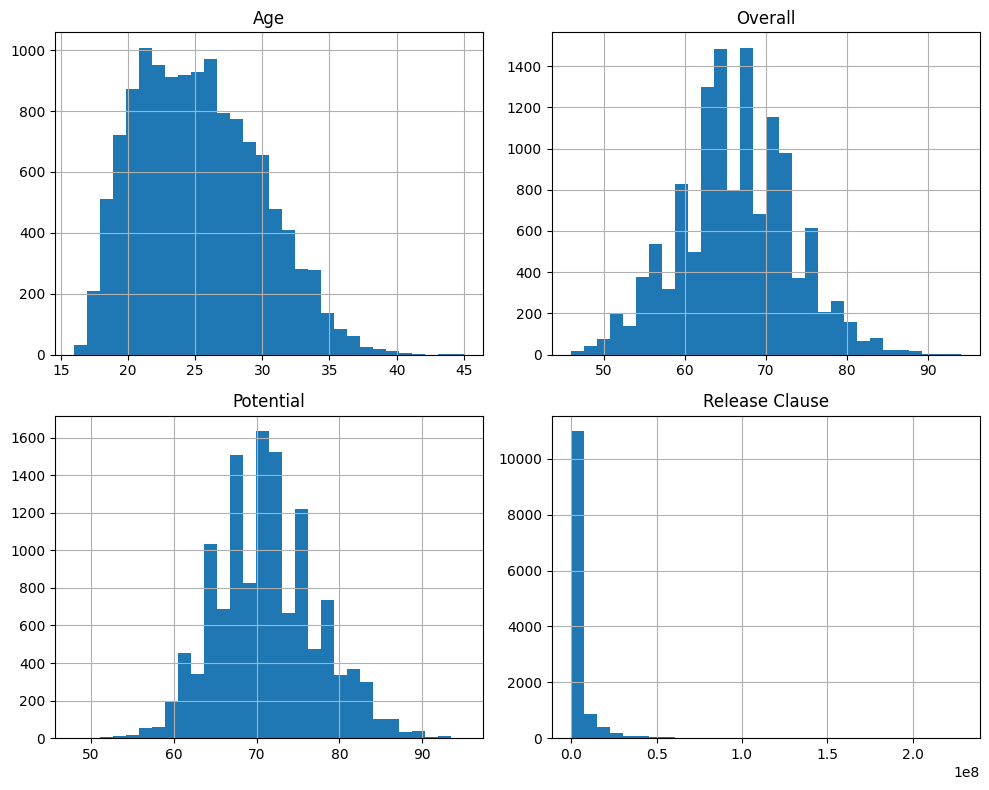

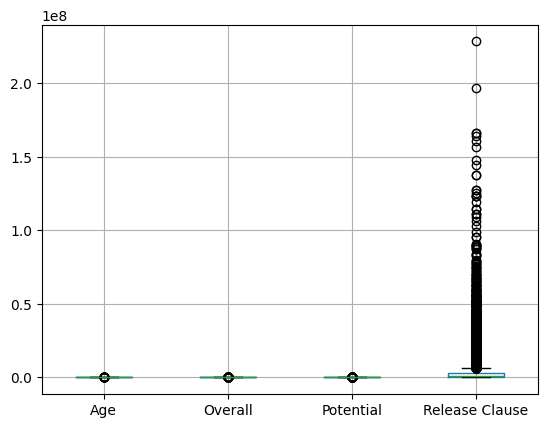

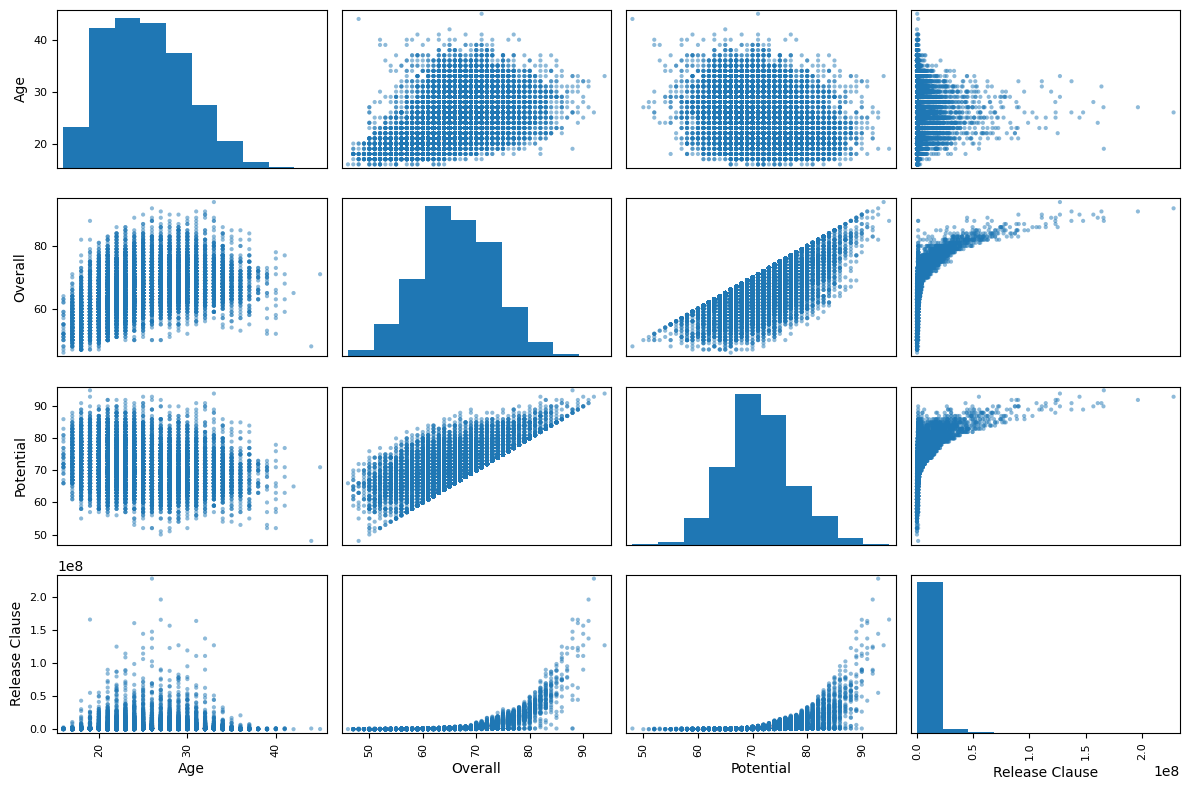

In [44]:
# Seleccionar atributos y crear DataFrame
Xm = pd.DataFrame(Xtrain_pre[['Age', 'Overall', 'Potential']], columns=['Age', 'Overall', 'Potential'])
Xm['Release Clause'] = ytrain_num  # Agregar la variable de salida

# Histograma de los datos preprocesados
Xm.hist(bins=30, figsize=(10, 8))
plt.tight_layout()
plt.show()

# Diagrama de caja de los datos preprocesados
Xm.boxplot()
plt.show()

# Matriz de dispersión de los datos preprocesados
from pandas.plotting import scatter_matrix
scatter_matrix(Xm, figsize=(12, 8))
plt.tight_layout()
plt.show()



## Datos preprocesados con `StandardScaler`

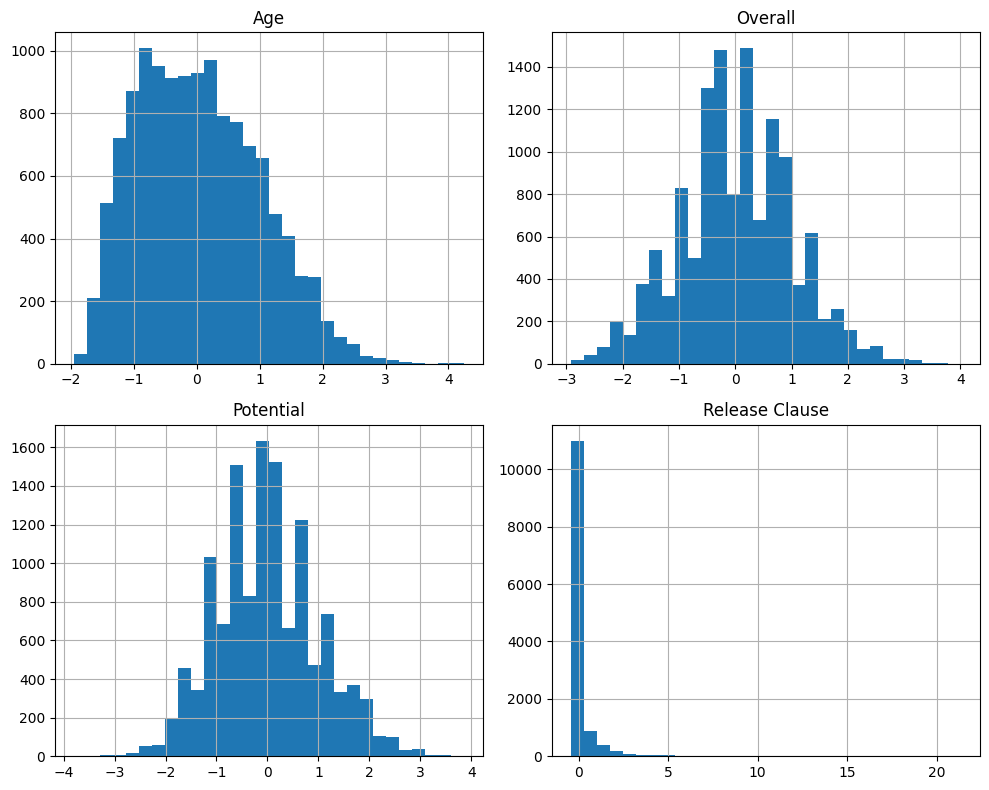

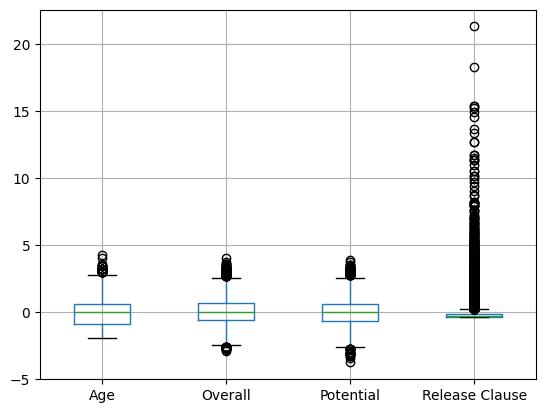

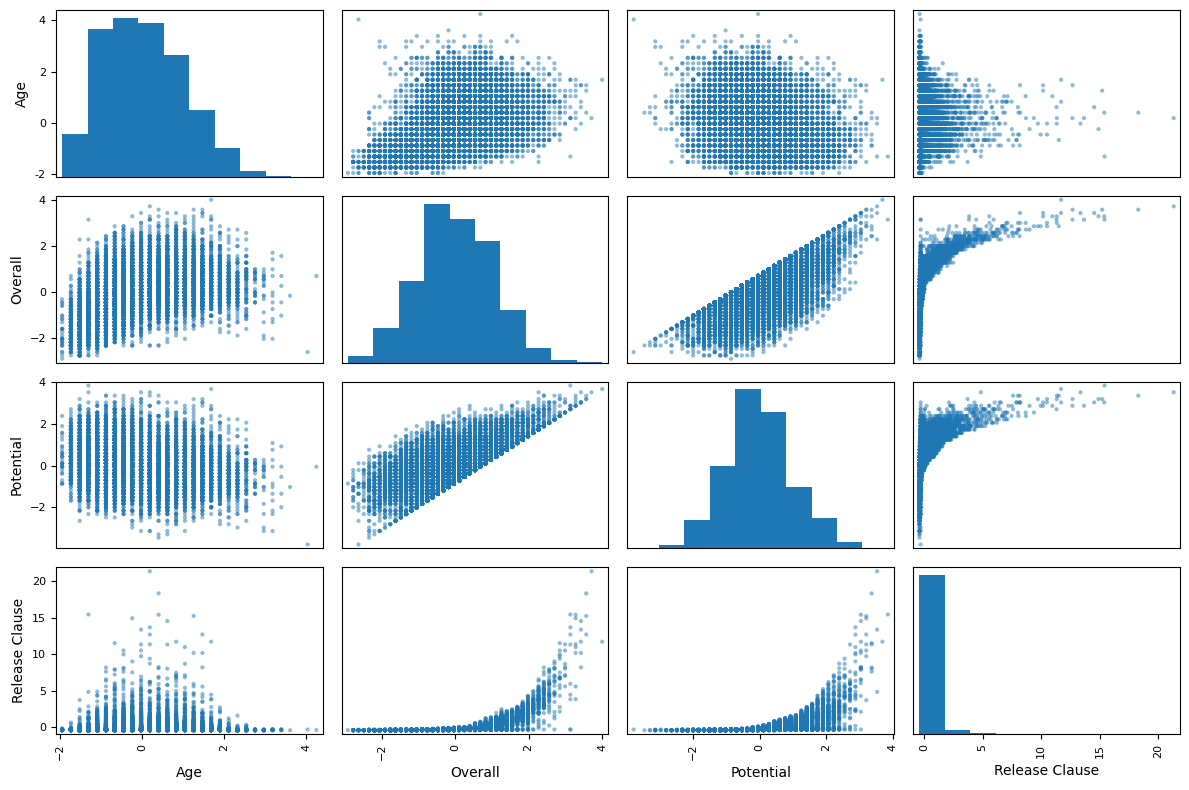

In [45]:

from sklearn.preprocessing import StandardScaler

# Aplicar StandardScaler
scaler = StandardScaler()
Xm_scaled = pd.DataFrame(scaler.fit_transform(Xm), columns=Xm.columns)

# Histograma de los datos escalados con StandardScaler
Xm_scaled.hist(bins=30, figsize=(10, 8))
plt.tight_layout()
plt.show()

# Diagrama de caja de los datos escalados con StandardScaler
Xm_scaled.boxplot()
plt.show()

# Matriz de dispersión de los datos escalados con StandardScaler
scatter_matrix(Xm_scaled, figsize=(12, 8))
plt.tight_layout()
plt.show()


## Datos Preprocesados con `MinMaxScaler`

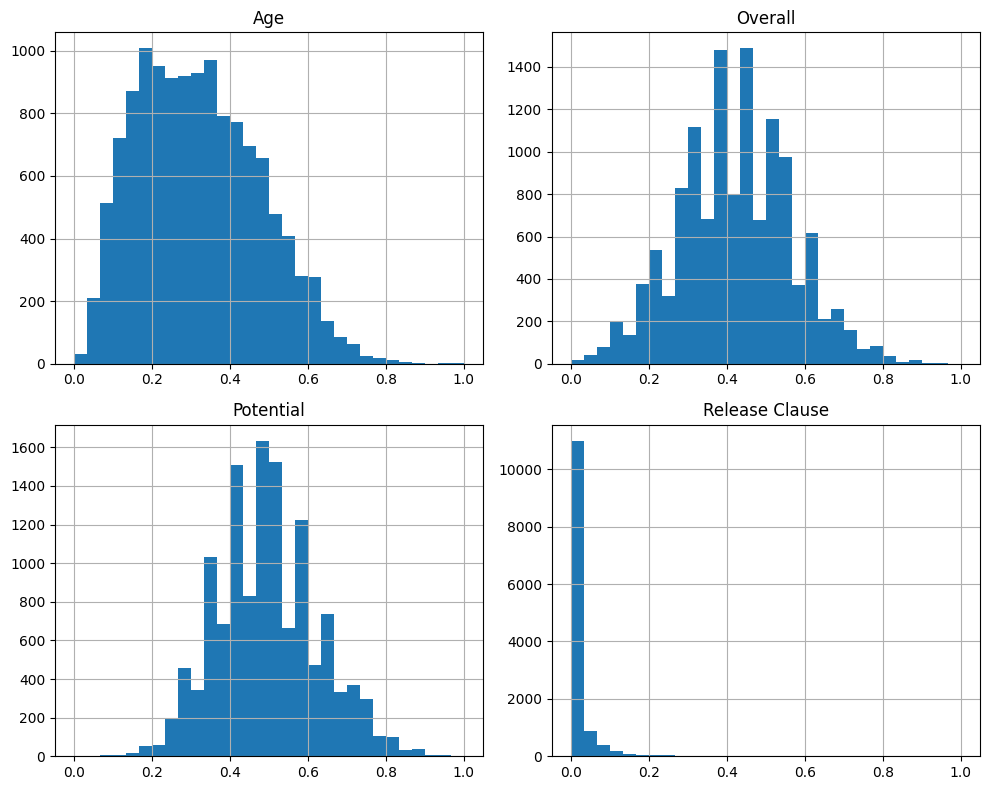

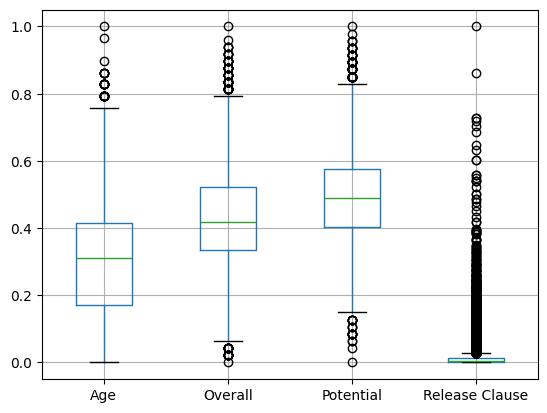

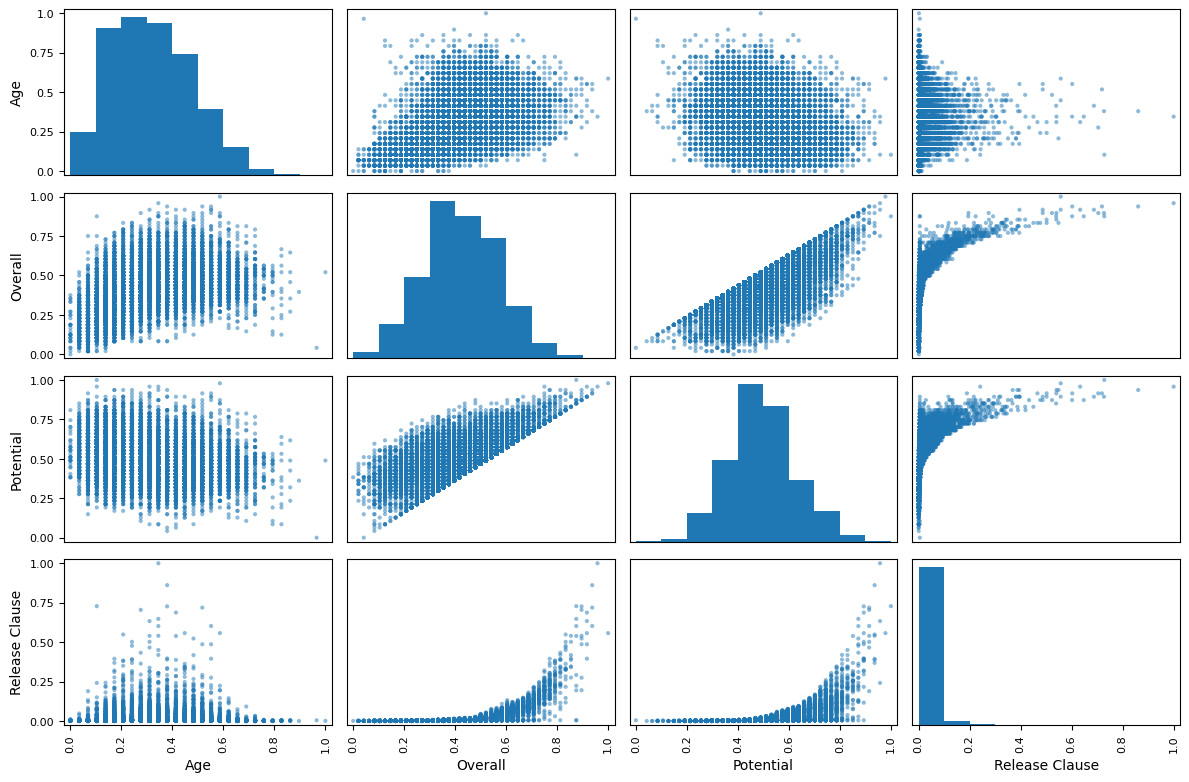

In [46]:
from sklearn.preprocessing import MinMaxScaler

# Aplicar MinMaxScaler
scaler = MinMaxScaler()
Xm_minmax = pd.DataFrame(scaler.fit_transform(Xm), columns=Xm.columns)

# Histograma de los datos escalados con MinMaxScaler
Xm_minmax.hist(bins=30, figsize=(10, 8))
plt.tight_layout()
plt.show()

# Diagrama de caja de los datos escalados con MinMaxScaler
Xm_minmax.boxplot()
plt.show()

# Matriz de dispersión de los datos escalados con MinMaxScaler
scatter_matrix(Xm_minmax, figsize=(12, 8))
plt.tight_layout()
plt.show()

# Ejercicio 3

1. Utilizando el método steps del pipeline, realice una gráfica de las cargas (pesos) del modelo lineal entrenado. Qué puede discutir al respecto?

2. Consulte y presente el modelo y problema de optimización de los siguientes regresores:

 - [LinearRegresor](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)
 - [Lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html)
 - [ElasticNet](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html)
 - [KernelRidge](https://scikit-learn.org/stable/modules/generated/sklearn.kernel_ridge.KernelRidge.html)
 - [SGDRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDRegressor.html)
 - [BayesianRidge](https://scikit-learn.org/stable/modules/linear_model.html#bayesian-ridge-regression)
 - [Gaussian Process Regressor](https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.GaussianProcessRegressor.html)

3. Utilizando un esquema de validación cruzada de 5 folds sobre el conjunto de entrenamiento preprocesado, compare el rendimiento en el conjunto de test de los regresores del punto 2. fijando el score del [gridsearch](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) en términos del error absoluto medio y el error cuádratico medio. Justifique los hiperparámetros a buscar y la rejilla de valores escogida para cada algoritmo según los modelos estudiados en clase y las respuestas del punto 2. Para el caso del kernelRidge y GPR se sugiere trabajar sobre un conjunto de train de 5000 puntos para evitar problemas de memoría en los cálculos de la matriz kernel (presente los resultados para kernel ridge utilizando una función rbf).



## Punto 1

In [47]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

# Definición de los pasos del pipeline
steps = [
    ('preproceso', mypre_fifa(col_euro=col_euro, col_stats=col_stats, cat_usr=cat_usr)),
    ('scaler', StandardScaler()),
    ('regresion', LinearRegression())
]

# Creación del pipeline completo
metodo_full = Pipeline(steps=steps)

# Entrenamiento del modelo con los datos de entrenamiento originales (sin preprocesar)
metodo_full.fit(Xtrain, ytrain_num)


Pipeline(steps=[('preproceso',
                 mypre_fifa(cat_usr={'Body Type': ['Messi', 'C. Ronaldo',
                                                   'Neymar', 'Lean', 'Normal',
                                                   'Courtois', 'Stocky',
                                                   'PLAYER_BODY_TYPE_25',
                                                   'Shaqiri', 'Akinfenwa'],
                                     'Club': ['FC Barcelona', 'Juventus',
                                              'Paris Saint-Germain',
                                              'Manchester United',
                                              'Manchester City', 'Chelsea',
                                              'Real Madrid', 'Atlético Madrid',
                                              'FC Bayern München',
                                              'Tottenham Hotspur', 'Liverpool'...
                                     'Work Rate': ['Medium/ Medium',
                                                   'High/ Low', 'High/ Medium',
                                                   'High/ High', 'Medium/ High',
                                                   'Medium/ Low', 'Low/ High',
                                                   'Low/ Medium', 'Low/ Low']},
                            col_euro=['Value', 'Wage'],
                            col_stats=['LS', 'ST', 'RS', 'LW', 'LF', 'CF', 'RF',
                                       'RW', 'LAM', 'CAM', 'RAM', 'LM', 'LCM',
                                       'CM', 'RCM', 'RM', 'LWB', 'LDM', 'CDM',
                                       'RDM', 'RWB', 'LB', 'LCB', 'CB', 'RCB',
                                       'RB'])),
                ('scaler', StandardScaler()),
                ('regresion', LinearRegression())])

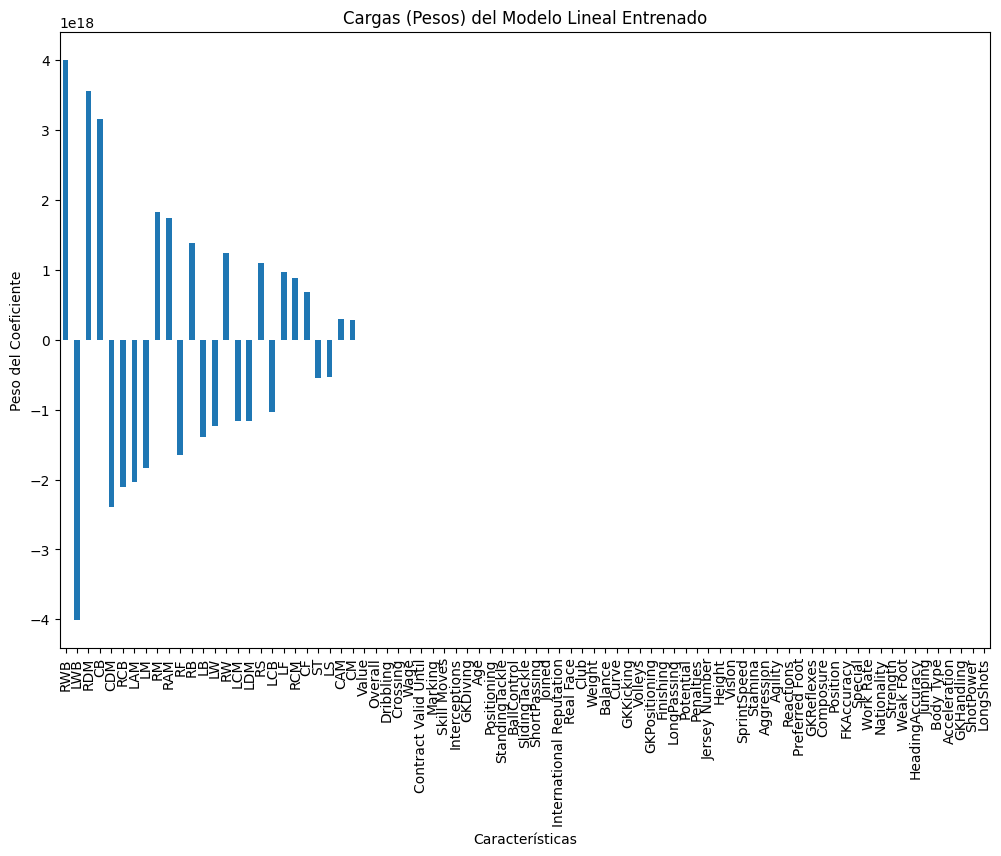

In [48]:
# Extraer los coeficientes del modelo lineal entrenado
coeficientes = metodo_full.named_steps['regresion'].coef_

# Obtener los nombres de las características después del preprocesamiento
# Necesitamos aplicar el preprocesamiento a Xtrain para obtener los nombres de las columnas
Xtrain_preprocessed = metodo_full.named_steps['preproceso'].transform(Xtrain)
feature_names = Xtrain_preprocessed.columns

# Crear un DataFrame para los coeficientes
import pandas as pd
import matplotlib.pyplot as plt

coef_df = pd.Series(coeficientes, index=feature_names)

# Ordenar los coeficientes por valor absoluto
coef_df_sorted = coef_df.reindex(coef_df.abs().sort_values(ascending=False).index)

# Graficar las cargas
plt.figure(figsize=(12, 8))
coef_df_sorted.plot(kind='bar')
plt.title('Cargas (Pesos) del Modelo Lineal Entrenado')
plt.ylabel('Peso del Coeficiente')
plt.xlabel('Características')
plt.show()


## Punto 2

### 1. Regresión Lineal (Linear Regression)

La regresión lineal busca ajustar una relación lineal entre las características y la variable objetivo.

**Modelo:**

$$
\hat{y} = X \beta + \varepsilon
$$

Donde:

- $X$ es la matriz de características.
- $\beta$ es el vector de coeficientes.
- $\varepsilon$ es el término de error.
- $\hat{y}$ es la predicción de la variable objetivo.

**Problema de Optimización:**

Minimizar la suma de los errores al cuadrado:

$$
\min_{\beta} \quad \frac{1}{2n} \| X \beta - y \|_2^2
$$

### 2. Lasso

El modelo Lasso agrega una penalización $\ell_1$ para realizar selección de características y promover soluciones esparsas.

**Modelo:**

$$
\hat{y} = X \beta + \varepsilon
$$

**Problema de Optimización:**

$$
\min_{\beta} \quad \frac{1}{2n} \| X \beta - y \|_2^2 + \alpha \| \beta \|_1
$$

Donde:

- $\alpha$ es el parámetro de regularización.
- $\| \beta \|_1 = \sum_{j=1}^{p} | \beta_j |$ es la norma $\ell_1$.

### 3. Elastic Net

Elastic Net combina las penalizaciones $\ell_1$ y $\ell_2$ para aprovechar las ventajas de Lasso y Ridge.

**Modelo:**

$$
\hat{y} = X \beta + \varepsilon
$$

**Problema de Optimización:**

$$
\min_{\beta} \quad \frac{1}{2n} \| X \beta - y \|_2^2 + \alpha \left( \rho \| \beta \|_1 + \frac{1 - \rho}{2} \| \beta \|_2^2 \right)
$$

Donde:

- $\rho$ controla el balance entre las penalizaciones $\ell_1$ y $\ell_2$.
- $\| \beta \|_2^2 = \sum_{j=1}^{p} \beta_j^2$ es la norma $\ell_2$ al cuadrado.

### 4. Kernel Ridge Regression

Kernel Ridge Regression combina la regresión Ridge con el truco del kernel para modelar relaciones no lineales.

**Modelo:**

$$
\hat{y} = K \alpha
$$

Donde:

- $K$ es la matriz kernel, $K_{ij} = k(\mathbf{x}_i, \mathbf{x}_j)$.
- $k$ es una función kernel (por ejemplo, el kernel RBF).

**Problema de Optimización:**

$$
\min_{\alpha} \quad \| K \alpha - y \|_2^2 + \lambda \alpha^\top K \alpha
$$

### 5. SGDRegressor

El `SGDRegressor` utiliza el Descenso de Gradiente Estocástico para optimizar modelos lineales.

**Modelo:**

$$
\hat{y} = X \beta + \varepsilon
$$

**Problema de Optimización:**

Minimizar la función de pérdida empírica con regularización:

$$
\min_{\beta} \quad \frac{1}{n} \sum_{i=1}^{n} L(y_i, \mathbf{x}_i^\top \beta) + \alpha R(\beta)
$$

Donde:

- $L$ es la función de pérdida (por ejemplo, pérdida cuadrática).
- $R(\beta)$ es el término de regularización ($\ell_1$, $\ell_2$ o Elastic Net).

### 6. Bayesian Ridge Regression

La regresión Bayesiana introduce un enfoque probabilístico, considerando distribuciones previas sobre los parámetros.

**Modelo:**

$$
y = X \beta + \varepsilon
$$

Con:

- $\varepsilon \sim \mathcal{N}(0, \lambda^{-1} I)$
- $\beta \sim \mathcal{N}(0, \alpha^{-1} I)$

**Estimación:**

Se busca la distribución posterior de $\beta$ dado $X$ y $y$:

$$
p(\beta | X, y) \propto p(y | X, \beta) p(\beta)
$$

### 7. Gaussian Process Regressor (GPR)

Los procesos Gaussianos modelan una distribución sobre funciones para capturar relaciones no lineales.

**Modelo:**

$$
f(\mathbf{x}) \sim \mathcal{GP}(m(\mathbf{x}), k(\mathbf{x}, \mathbf{x'}))
$$

Donde:

- $m(\mathbf{x})$ es la función de media (generalmente cero).
- $k(\mathbf{x}, \mathbf{x'})$ es la función de covarianza o kernel.

**Predicción:**

La distribución predictiva es:

$$
p(f_* | X, y, X_*) = \mathcal{N}(f_* | \bar{f}_*, \operatorname{cov}(f_*))
$$

Con:

$$
\bar{f}_* = K(X_*, X)[K(X, X) + \sigma_n^2 I]^{-1} y
$$


## Punto 3 

In [49]:
# Reiniciar los índices de Xtrain_pre
Xtrain_pre_reset = Xtrain_pre.reset_index(drop=True)

# Convertir ytrain_num en un DataFrame y reiniciar su índice
ytrain_num_df = pd.DataFrame(ytrain_num, columns=['target']).reset_index(drop=True)

# Tomar una muestra de Xtrain_pre_reset
Xtrain_sample = Xtrain_pre_reset.sample(n=5000)

# Obtener los índices de la muestra
sample_indices = Xtrain_sample.index

# Obtener ytrain_sample utilizando los índices de la muestra
ytrain_sample = ytrain_num_df.loc[sample_indices, 'target'].values


In [50]:
from sklearn.linear_model import LinearRegression

linear_reg = LinearRegression()
param_grid_lr = {}


In [51]:
from sklearn.linear_model import Lasso

lasso = Lasso(max_iter=10000)
param_grid_lasso = {'regresor__alpha': [0.1, 1, 10, 100]}


In [52]:
from sklearn.linear_model import ElasticNet

elastic_net = ElasticNet(max_iter=10000)
param_grid_elastic = {
    'regresor__alpha': [0.1, 1, 10],
    'regresor__l1_ratio': [0.1, 0.5, 0.9]
}


In [53]:
from sklearn.linear_model import SGDRegressor

sgd = SGDRegressor(max_iter=1000, tol=1e-3)
param_grid_sgd = {
    'regresor__alpha': [0.0001, 0.001],
    'regresor__penalty': ['l2', 'l1', 'elasticnet']
}


In [54]:
from sklearn.linear_model import BayesianRidge

bayesian_ridge = BayesianRidge()
param_grid_br = {
    'regresor__alpha_1': [1e-6, 1e-5],
    'regresor__lambda_1': [1e-6, 1e-5]
}


In [55]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

kernel = C(1.0) * RBF(length_scale=1.0)
gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=1)
param_grid_gpr = {'regresor__alpha': [1e-10, 1e-5]}


In [56]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error

def evaluar_modelo(modelo, param_grid, X, y, nombre_modelo):
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('regresor', modelo)
    ])
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
    grid_search.fit(X, y)
    mejor_modelo = grid_search.best_estimator_
    y_pred = mejor_modelo.predict(Xtest_pre)
    mae = mean_absolute_error(ytest_num, y_pred)
    mse = mean_squared_error(ytest_num, y_pred)
    print(f"Modelo: {nombre_modelo}")
    print(f"Mejores hiperparámetros: {grid_search.best_params_}")
    print(f"MAE en test: {mae}")
    print(f"MSE en test: {mse}\n")


In [57]:
# Linear Regression
evaluar_modelo(linear_reg, param_grid_lr, Xtrain_pre, ytrain_num, 'Linear Regression')

# Lasso
evaluar_modelo(lasso, param_grid_lasso, Xtrain_pre, ytrain_num, 'Lasso')

# Elastic Net
evaluar_modelo(elastic_net, param_grid_elastic, Xtrain_pre, ytrain_num, 'Elastic Net')

# Kernel Ridge
evaluar_modelo(kr, param_grid_kr, Xtrain_sample, ytrain_sample, 'Kernel Ridge')

# SGDRegressor
evaluar_modelo(sgd, param_grid_sgd, Xtrain_pre, ytrain_num, 'SGDRegressor')

# Bayesian Ridge
evaluar_modelo(bayesian_ridge, param_grid_br, Xtrain_pre, ytrain_num, 'Bayesian Ridge')

# Gaussian Process Regressor
evaluar_modelo(gpr, param_grid_gpr, Xtrain_sample, ytrain_sample, 'Gaussian Process Regressor')


Modelo: Linear Regression
Mejores hiperparámetros: {}
MAE en test: 963980.5444591452
MSE en test: 5139148003322.573



/home/felipe/Documents/Trabajos U/Aprendizaje de Maquina/env/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.177e+16, tolerance: 1.103e+14
  model = cd_fast.enet_coordinate_descent(
/home/felipe/Documents/Trabajos U/Aprendizaje de Maquina/env/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.301e+16, tolerance: 1.084e+14
  model = cd_fast.enet_coordinate_descent(
/home/felipe/Documents/Trabajos U/Aprendizaje de Maquina/env/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want 

Modelo: Lasso
Mejores hiperparámetros: {'regresor__alpha': 100}
MAE en test: 895177.9570968837
MSE en test: 5077604933934.808

Modelo: Elastic Net
Mejores hiperparámetros: {'regresor__alpha': 0.1, 'regresor__l1_ratio': 0.9}
MAE en test: 875020.87267307
MSE en test: 5138531504048.668



NameError: name 'kr' is not defined